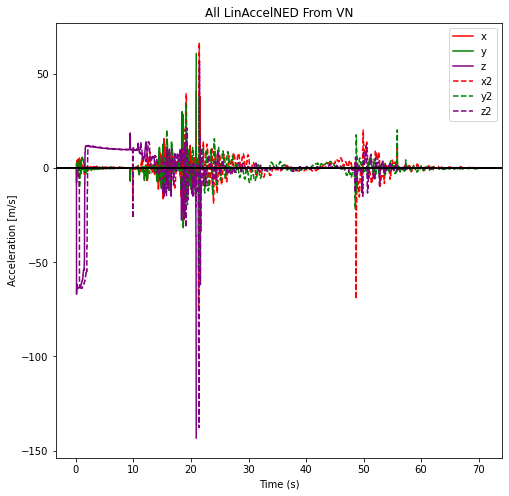

In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, pi, atan2, asin, sqrt
import matplotlib.pyplot as plt
from scipy import integrate
from model_funcs import *
LSM_datafile = "LSM_LOG_20220402-132105"
SIFT1_datafile = "SIFT1_LOG_20220402_124920"
SIFT2_datafile = "SIFT2_LOG_20220402_124347"
Full_LSM_datafile = "FULL_LSM"

# Parameters
dt = 0.001
B = 6.5*10**-3   # temperature lapse rate in troposphere in K/m
R = 287   # ideal gas constant in J/(kg.K)
g = 9.80665  # gravity at sea level in m/s2
T0 = 288.15   # standard air temperature in K
P0 = 101.325   # standard air pressure in kPa
pi = 3.1415
ft = 3.2884  # ft/m
################## CONSTANTS ##################
# gravity
g = 9.81  # m/s^2
# m to ft
ft = 3.2884  # ft/m

################## DATA FRAME ##################
datafile = '../Data/Fullscale2/' + SIFT1_datafile + '.csv'
fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  'Accel X', 'Accel Y', 'Accel Z'
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata1 = all_time
tdata1 = tdata1 - all_time[0]

ax_vn1 = df['LinearAccelNed X']
ay_vn1 = df['LinearAccelNed Y']
az_vn1 = df['LinearAccelNed Z']

ax_g1 = df['LinearAccelNed X']/9.8
ay_g1 = df['LinearAccelNed Y']/9.8
az_g1 = df['LinearAccelNed Z']/-9.8

################## DATA FRAME ##################
datafile = '../Data/Fullscale2/' + SIFT2_datafile + '.csv'
fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  'Accel X', 'Accel Y', 'Accel Z'
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata2 = all_time
tdata2 = tdata2 - all_time[0]

ax_vn2 = df['LinearAccelNed X']
ay_vn2= df['LinearAccelNed Y']
az_vn2 = df['LinearAccelNed Z']

ax_g2 = df['LinearAccelNed X']/9.8
ay_g2 = df['LinearAccelNed Y']/9.8
az_g2 = df['LinearAccelNed Z']/-9.8


fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata1, ax_vn1, color='red', label='x')
l3 = ax.plot(tdata1, ay_vn1, color='green', label='y')
l4 = ax.plot(tdata1, az_vn1, color='purple', label='z')

l2 = ax.plot(tdata2, ax_vn2, color='red', label='x2', linestyle='--')
l3 = ax.plot(tdata2, ay_vn2, color='green', label='y2', linestyle='--')
l4 = ax.plot(tdata2, az_vn2, color='purple', label='z2', linestyle='--')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("All LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [m/s]")
ax.legend()
plt.show()

## Post Drogue

In [2]:
import scipy
ms2mph = 0.6818182*ft
gs2mph = ms2mph * 9.8


def calc_moving_avg(axg21t, n, tdata21, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80):        
    if dynamic_window:
        axg21s_1 = pd.Series(axg21t[0:dynamic_n_timing]).rolling(window=n).mean().iloc[n-1:].values
        axg21s_2 = pd.Series(axg21t).rolling(window=dynamic_n).mean().iloc[n-1:].values[dynamic_n_timing:]
        new_axg21s = list(axg21s_1) + list(axg21s_2)
    else:
        axg21s = pd.Series(axg21t).rolling(window=n).mean().iloc[n-1:].values
        new_axg21s = list(axg21s)
    while len(new_axg21s) < len(tdata21):
        new_axg21s = [0] + list(new_axg21s) + [0]
    return new_axg21s


def find_peak_and_wait(az, t, thresh=40, post_drogue_delay=1, signal_length=3, time=1, t_sim_drogue=9.85, t_sim_landing=90):
    '''
    USE Z FOR DETECTION BUT THE SIGNAL WE WANT IS IN X AND Y
    '''
    azn = np.array(az, float)
    
    if time==0:
        above_threshold = abs(azn) > thresh
        takeoff_idx = list(above_threshold).index(True)

        # Get past the full takeoff spike
        post_takeoff_idx = takeoff_idx
        if azn[post_takeoff_idx] > 0:
            flip = -1
        else:
            flip = 1
        takeoff_offset = 0
        while (azn[post_takeoff_idx]*flip < 0):
            post_takeoff_idx += 1
        
        # NOW FIND DROGUE
        above_threshold = abs(azn[post_takeoff_idx:]) > thresh
        takeoff_idx = list(above_threshold).index(True)
        
        # Fix this for fullscale.  Subscale won't work cause there's not actual drogue spike
        ########################################################################
        # Now get past the transcience
        while t[past_takeoff_idx] < t[takeoff_idx+takeoff_offset]:
            past_takeoff_idx += 1

        a_1 = np.average(azn[takeoff_idx:drogue_idx])

        end_drogue_idx = drogue_idx
        while t[end_drogue_idx] < (t[drogue_idx] + signal_length):
            end_drogue_idx += 1
            
        landing_idx = end_drogue_idx
        while t[landing_idx] < t_sim_landing:
            landing_idx += 1

        return takeoff_idx, drogue_idx, end_drogue_idx, landing_idx, a_1
        ########################################################################
    elif time==1:
        # Detect takeoff
        takeoff_idx = np.argmax(abs(azn)>thresh)
        drogue_idx = takeoff_idx
        
        # Wait until sim_drogue
        t_takeoff = t[takeoff_idx]
        t_drogue = t_takeoff
        while t_drogue < (t_takeoff + t_sim_drogue):
            drogue_idx += 1
            t_drogue = t[drogue_idx]
            
        # Now wait until takeoff_delay passes
        t_signal = t_drogue
        end_drogue_idx = drogue_idx
        while t_signal < (t_drogue + post_drogue_delay):
            end_drogue_idx += 1
            t_signal = t[end_drogue_idx]
            
        # Get the resting acceleration
        a_1 = np.average(azn[drogue_idx:end_drogue_idx])
        
        landing_idx = end_drogue_idx
        while t[landing_idx] < t_sim_landing:
            landing_idx += 1
        
        return takeoff_idx, drogue_idx, end_drogue_idx, landing_idx, a_1
    else:
        print("BAD INPUT - FIX TIME PARAMETER")
        return -1

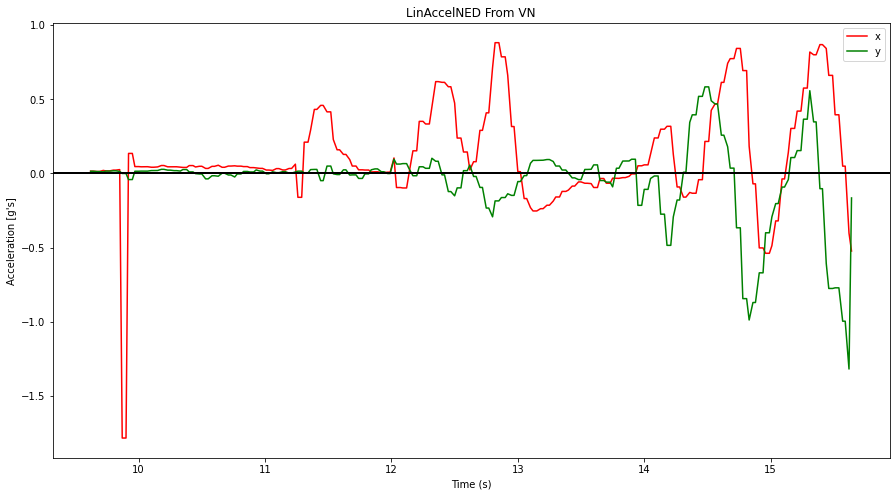

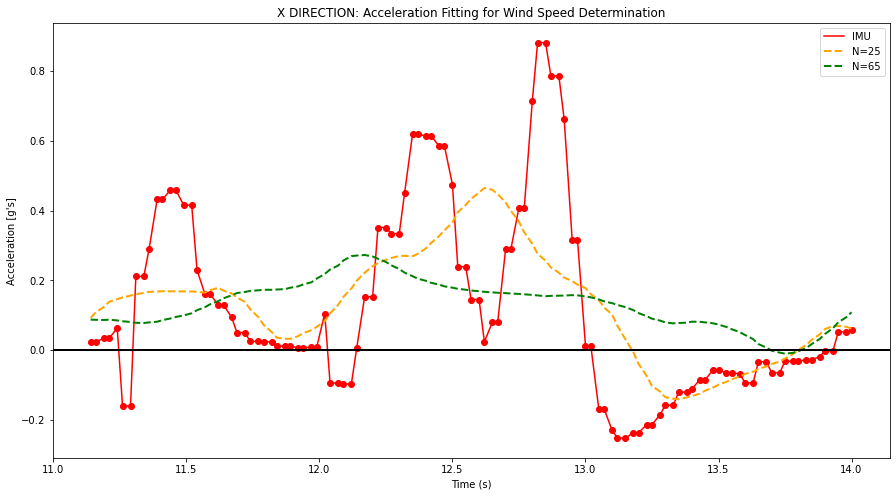

Estimated Wind Speed via Original IMU Signal: 9.40132957 mph
Estimated Wind Speed via Moving Average (25): 9.70378113 mph
Estimated Wind Speed via Moving Average (65): 9.85519524 mph


In [3]:
start_main = 380
end_main = 620

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata2[start_main:end_main], ax_g2[start_main:end_main], color='red', label='x')
l2 = ax.plot(tdata2[start_main:end_main], ay_g2[start_main:end_main], color='green', label='y')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
#plt.ylim((-2, 2))

ax.legend()
plt.show()

#calculate moving average
#dynamic_window=False, dynamic_n_timing=140, dynamic_n=80
axg21t = calc_moving_avg(ax_g2, 25, tdata2)
new_axg21s_25 = axg21t[440:555]
#new_axg21s_45 = calc_moving_avg(axg21t, 45, tdata21)
axg21t = calc_moving_avg(ax_g2, 65, tdata2)
new_axg21s_65 = axg21t[440:555]
#new_axg21s_85 = calc_moving_avg(axg21t, 85, tdata21)

axg21t = ax_g2[440:555] #620
tdata21 = tdata2[440:555]
dt = tdata2[1]

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, axg21t, color='red', label='IMU')
l2 = ax.scatter(tdata21, axg21t, color='red')
l25 = ax.plot(tdata21, new_axg21s_25, color='orange', label='N=25', linewidth=2, linestyle="--")
#l45 = ax.plot(tdata21, new_axg21s_45, color='blue', label='N=45', linewidth=2, linestyle="--")
l65 = ax.plot(tdata21, new_axg21s_65, color='green', label='N=65', linewidth=2, linestyle="--")
#l85 = ax.plot(tdata21, new_axg21s_85, color='purple', label='N=85', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("X DIRECTION: Acceleration Fitting for Wind Speed Determination")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
#plt.ylim((-1.1, 1.1))

ax.legend()
plt.show()

result_trapz_IMU = scipy.integrate.trapz(axg21t, dx=dt)
result_trapz_MA25 = scipy.integrate.trapz(new_axg21s_25, dx=dt)
result_trapz_MA65 = scipy.integrate.trapz(new_axg21s_65, dx=dt)

print(f"Estimated Wind Speed via Original IMU Signal: {gs2mph*result_trapz_IMU:.8f} mph")
print(f"Estimated Wind Speed via Moving Average (25): {gs2mph*result_trapz_MA25:.8f} mph")
print(f"Estimated Wind Speed via Moving Average (65): {gs2mph*result_trapz_MA65:.8f} mph")

(24, 414, 454, 1983, 10.137089749999998)


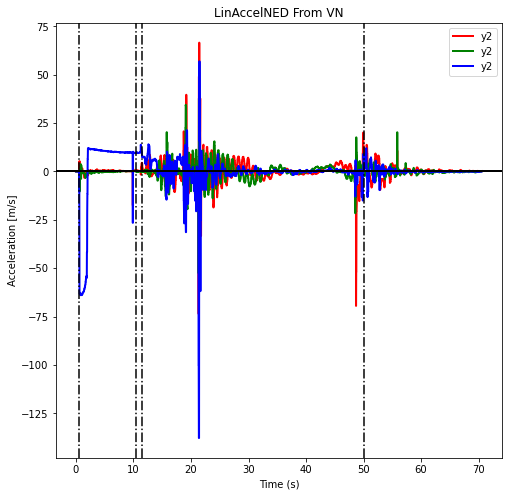

In [4]:
takeoff_idx, drogue_idx, post_drogue_idx, landing_idx, a_1 = find_peak_and_wait(az_vn2, tdata2, thresh=50, post_drogue_delay=1, signal_length=3, time=1, t_sim_drogue=9.85, t_sim_landing=50)
print((takeoff_idx, drogue_idx, post_drogue_idx, landing_idx, a_1))

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l3 = ax.plot(tdata2, ax_vn2, color='red', label='y2', linewidth=2)
l3 = ax.plot(tdata2, ay_vn2, color='green', label='y2', linewidth=2)
l3 = ax.plot(tdata2, az_vn2, color='blue', label='y2', linewidth=2)
l5 = plt.axhline(y=0, color='black', linewidth=2)
#l6 = plt.axvline(tdata2[a1], color='red', linestyle='--')
l6 = plt.axvline(tdata2[takeoff_idx], color='black', linestyle='-.')
l6 = plt.axvline(tdata2[drogue_idx], color='black', linestyle='-.')
l6 = plt.axvline(tdata2[post_drogue_idx], color='black', linestyle='-.')
l6 = plt.axvline(tdata2[landing_idx], color='black', linestyle='-.')
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [m/s]")
ax.legend()
plt.show()

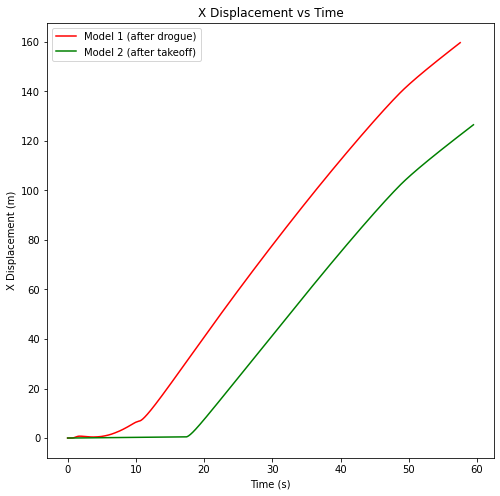

In [5]:
#def calc_displacement(datafile, zero_out=False):
zero_out = 0

# Read in the dataframe
fields = ['Timestamp', 'Pres',
'Roll', 'Pitch', 'Yaw',
'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z']

datafile = '../Data/Fullscale2/' + SIFT2_datafile + '.csv'
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

# Read Data Fields
imu_t = df['Timestamp'].values
imu_t = imu_t - imu_t[0]
imu_N = len(imu_t)
imu_ax = df['LinearAccelNed X'].values
imu_ay = df['LinearAccelNed Y'].values
imu_az = df['LinearAccelNed Z'].values * -1
imu_pres = df['Pres']

################## INIT VECTORS  ##################
imu_vx, imu_vy, imu_vz, imu_x, imu_y, imu_z = (np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)))

################## Find velocity and position  ##################
for i in range(imu_N-1):
    imu_vz[i+1] = imu_vz[i] + imu_az[i]*(imu_t[i+1] - imu_t[i])
    imu_z[i+1] = imu_z[i] + imu_vz[i]*(imu_t[i+1] - imu_t[i])

    imu_vx[i+1] = imu_vx[i] + imu_ax[i]*(imu_t[i+1] - imu_t[i])
    imu_x[i+1] = imu_x[i] + imu_vx[i]*(imu_t[i+1] - imu_t[i])

    imu_vy[i+1] = imu_vy[i] + imu_ay[i]*(imu_t[i+1] - imu_t[i])
    imu_y[i+1] = imu_y[i] + imu_vy[i]*(imu_t[i+1] - imu_t[i])

################## Find alt  ##################
def nasa_pres(P, P0, T0, R, B, g):
    imu_temp = T0*(P/P0)**(R*B/g)
    imu_alt = (T0 - imu_temp)/B
    return imu_alt

vec_NASA_pres = np.vectorize(nasa_pres)
imu_alt = vec_NASA_pres(imu_pres, P0, T0, R, B, g)   # * ft + 600
imu_alt = imu_alt - imu_alt[imu_N-1]
imu_alt = [val if val > 0 else 0 for val in imu_alt]

# Find drogue peak and calc wind velocity
takeoff_time, imu_start_time, imu_end_time, landing_idx, a_1 = find_peak_and_wait(az_vn2, tdata2, thresh=50, post_drogue_delay=1, signal_length=3, time=1, t_sim_drogue=9.85, t_sim_landing=50)

trunc_signal = imu_ax[imu_start_time:imu_end_time]
trunc_time = imu_t[imu_start_time:imu_end_time]

if zero_out and len(trunc_signal[trunc_signal > 0])>0 and len(trunc_signal[trunc_signal < 0])>0:
    smoothed_signal = [0]
else:
    smoothed_signal = calc_moving_avg(imu_ax, 25, imu_t, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80)
    smoothed_signal = smoothed_signal[imu_start_time:imu_end_time]

if max(np.array(smoothed_signal)) > 0.1:
    max_accel = max(np.array(smoothed_signal))
    flip = 1
else:
    max_accel = max(abs(np.array(smoothed_signal)))
    flip = -1

## DERIVED PARAMETERS
w_0_mph = gs2mph*result_trapz_IMU
w_0 = w_0_mph*0.44704
K = a_1/w_0**2 
z_0 = max(imu_alt) # apogee altitude in m

################## CONSTANT WIND PROFILE & AIR DENSITY  ##################
wind_profile_x = np.zeros((imu_N))
density_profile = np.zeros((imu_N))

z0 = max(imu_alt) # apogee altitude in m

for i in range(imu_N):
    T = T0 - B * imu_alt[i]
    P = P0 * 1000 * (T/T0)**(g/(R*B))
    density_profile[i] = P/(R*T)
    if imu_alt[i] < 2:
        wind_profile_x[i] = w_0*((2/z0)**(1/7))
    else:
        wind_profile_x[i] = w_0*((imu_alt[i]/z0)**(1/7))

x1, t1 = model1(imu_t[imu_start_time], imu_t, imu_ax, imu_vx, imu_x, dt, a_1, imu_alt, wind_profile_x, density_profile, K)
x2, t2 = model2(imu_t, dt, imu_alt, wind_profile_x, density_profile, K)
x1 = x1[:landing_idx]
t1 = t1[:landing_idx]
x2 = x2[:landing_idx]
t2 = t2[:landing_idx]

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(t1, x1*flip, color='red', label='Model 1 (after drogue)')
ax.plot(t2, x2*flip, color='green', label='Model 2 (after takeoff)')
ax.set_title("X Displacement vs Time")  # 'interpreter','latex', 'FontSize', 16
ax.set_xlabel("Time (s)")  # 'interpreter','latex', 'FontSize', 16
ax.set_ylabel("X Displacement (m)")  # 'interpreter','latex', 'FontSize', 16
ax.legend()
plt.show()

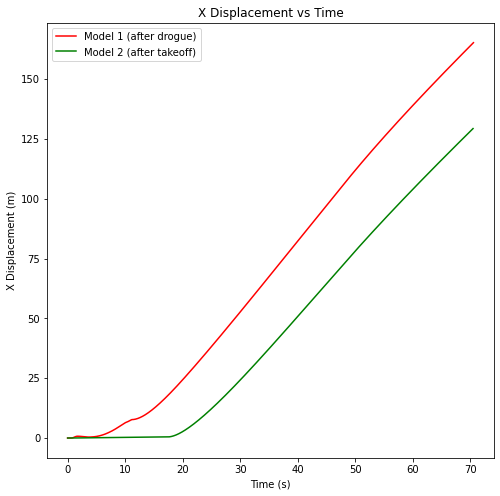

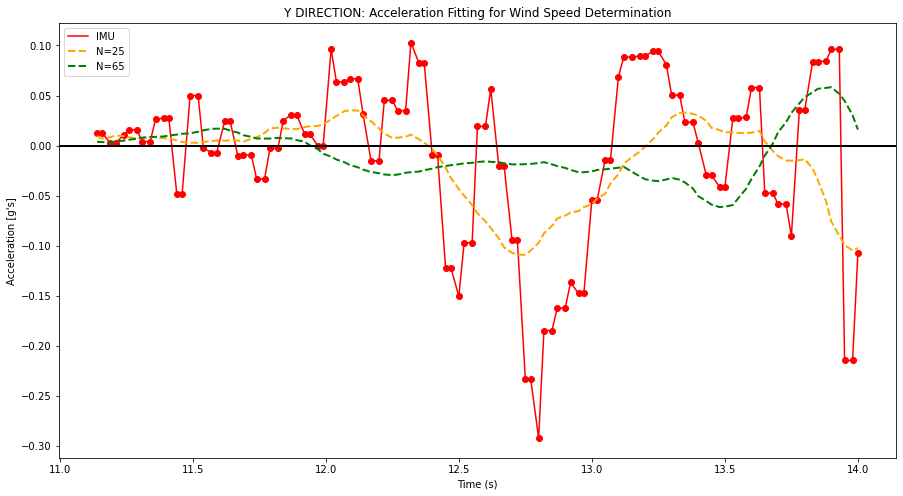

Estimated Wind Speed via Original IMU Signal: -0.75210325 mph
Estimated Wind Speed via Moving Average (25): -1.04254520 mph
Estimated Wind Speed via Moving Average (65): -0.66226777 mph


In [6]:
#def calc_displacement(datafile, zero_out=False):
zero_out = 0

# Read in the dataframe
fields = ['Timestamp', 'Pres',
'Roll', 'Pitch', 'Yaw',
'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z']

datafile = '../Data/Fullscale2/' + SIFT2_datafile + '.csv'
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

# Read Data Fields
imu_t = df['Timestamp'].values
imu_t = imu_t - imu_t[0]
imu_N = len(imu_t)
imu_ax = df['LinearAccelNed X'].values
imu_ay = df['LinearAccelNed Y'].values
imu_az = df['LinearAccelNed Z'].values * -1
imu_pres = df['Pres']

################## INIT VECTORS  ##################
imu_vx, imu_vy, imu_vz, imu_x, imu_y, imu_z = (np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)))

################## Find velocity and position  ##################
for i in range(imu_N-1):
    imu_vz[i+1] = imu_vz[i] + imu_az[i]*(imu_t[i+1] - imu_t[i])
    imu_z[i+1] = imu_z[i] + imu_vz[i]*(imu_t[i+1] - imu_t[i])

    imu_vx[i+1] = imu_vx[i] + imu_ax[i]*(imu_t[i+1] - imu_t[i])
    imu_x[i+1] = imu_x[i] + imu_vx[i]*(imu_t[i+1] - imu_t[i])

    imu_vy[i+1] = imu_vy[i] + imu_ay[i]*(imu_t[i+1] - imu_t[i])
    imu_y[i+1] = imu_y[i] + imu_vy[i]*(imu_t[i+1] - imu_t[i])

################## Find alt  ##################
def nasa_pres(P, P0, T0, R, B, g):
    imu_temp = T0*(P/P0)**(R*B/g)
    imu_alt = (T0 - imu_temp)/B
    return imu_alt

vec_NASA_pres = np.vectorize(nasa_pres)
imu_alt = vec_NASA_pres(imu_pres, P0, T0, R, B, g)   # * ft + 600
imu_alt = imu_alt - imu_alt[imu_N-1]
imu_alt = [val if val > 0 else 0 for val in imu_alt]

# Find drogue peak and calc wind velocity
#imu_start_time, imu_end_time, takeoff_time, a_1 = find_peak_and_wait(np.array(imu_ax), imu_t, takeoff_delay=1.5, signal_length=2)
a_1 = 1
imu_start_time = 440
imu_end_time = 555
takeoff_time = 0

trunc_signal = imu_ax[imu_start_time:imu_end_time]
trunc_time = imu_t[imu_start_time:imu_end_time]

if zero_out and len(trunc_signal[trunc_signal > 0])>0 and len(trunc_signal[trunc_signal < 0])>0:
    smoothed_signal = [0]
else:
    smoothed_signal = calc_moving_avg(imu_ax, 25, imu_t, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80)
    smoothed_signal = smoothed_signal[imu_start_time:imu_end_time]

if max(np.array(smoothed_signal)) > 0.1:
    max_accel = max(np.array(smoothed_signal))
    flip = 1
else:
    max_accel = max(abs(np.array(smoothed_signal)))
    flip = -1

## DERIVED PARAMETERS
w_0_mph = gs2mph*result_trapz_IMU
w_0 = w_0_mph*0.44704
K = a_1/w_0**2 
z_0 = max(imu_alt) # apogee altitude in m

################## CONSTANT WIND PROFILE & AIR DENSITY  ##################
wind_profile_x = np.zeros((imu_N))
density_profile = np.zeros((imu_N))

z0 = max(imu_alt) # apogee altitude in m

for i in range(imu_N):
    T = T0 - B * imu_alt[i]
    P = P0 * 1000 * (T/T0)**(g/(R*B))
    density_profile[i] = P/(R*T)
    if imu_alt[i] < 2:
        wind_profile_x[i] = w_0*((2/z0)**(1/7))
    else:
        wind_profile_x[i] = w_0*((imu_alt[i]/z0)**(1/7))

x1, t1 = model1(imu_t[imu_start_time], imu_t, imu_ax, imu_vx, imu_x, dt, a_1, imu_alt, wind_profile_x, density_profile, K)
x2, t2 = model2(imu_t, dt, imu_alt, wind_profile_x, density_profile, K)

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(t1, x1*flip, color='red', label='Model 1 (after drogue)')
ax.plot(t2, x2*flip, color='green', label='Model 2 (after takeoff)')
ax.set_title("X Displacement vs Time")  # 'interpreter','latex', 'FontSize', 16
ax.set_xlabel("Time (s)")  # 'interpreter','latex', 'FontSize', 16
ax.set_ylabel("X Displacement (m)")  # 'interpreter','latex', 'FontSize', 16
ax.legend()
plt.show()

#calculate moving average
#dynamic_window=False, dynamic_n_timing=140, dynamic_n=80
axg21t = calc_moving_avg(ay_g2, 25, tdata2)
new_axg21s_25 = axg21t[440:555]
#new_axg21s_45 = calc_moving_avg(axg21t, 45, tdata21)
axg21t = calc_moving_avg(ay_g2, 65, tdata2)
new_axg21s_65 = axg21t[440:555]
#new_axg21s_85 = calc_moving_avg(axg21t, 85, tdata21)

axg21t = ay_g2[440:555] #620
tdata21 = tdata2[440:555]
dt = tdata2[1]

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, axg21t, color='red', label='IMU')
l2 = ax.scatter(tdata21, axg21t, color='red')
l25 = ax.plot(tdata21, new_axg21s_25, color='orange', label='N=25', linewidth=2, linestyle="--")
#l45 = ax.plot(tdata21, new_axg21s_45, color='blue', label='N=45', linewidth=2, linestyle="--")
l65 = ax.plot(tdata21, new_axg21s_65, color='green', label='N=65', linewidth=2, linestyle="--")
#l85 = ax.plot(tdata21, new_axg21s_85, color='purple', label='N=85', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Y DIRECTION: Acceleration Fitting for Wind Speed Determination")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
#plt.ylim((-1.1, 1.1))

ax.legend()
plt.show()

result_trapz_IMU = scipy.integrate.trapz(axg21t, dx=dt)
result_trapz_MA25 = scipy.integrate.trapz(new_axg21s_25, dx=dt)
result_trapz_MA65 = scipy.integrate.trapz(new_axg21s_65, dx=dt)

print(f"Estimated Wind Speed via Original IMU Signal: {gs2mph*result_trapz_IMU:.8f} mph")
print(f"Estimated Wind Speed via Moving Average (25): {gs2mph*result_trapz_MA25:.8f} mph")
print(f"Estimated Wind Speed via Moving Average (65): {gs2mph*result_trapz_MA65:.8f} mph")